In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import sys


import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
import torchvision
from torchvision import datasets, models, transforms
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
BASE_DIR = "../../../data/cassava-leaf-disease-classification"
train_dir = os.path.join(BASE_DIR, 'train_images/')
test_dir = os.path.join(BASE_DIR, "test_images/")
print(train_dir)

../../../data/cassava-leaf-disease-classification\train_images/


In [3]:
#日付を取得
import datetime as dt

dt_now = dt.datetime.now()
directory_name = dt_now.strftime('%Y%m%d%H')
create_directory = BASE_DIR + '/models/' + directory_name
if(not (os.path.exists(create_directory))):
    os.mkdir(create_directory)

In [4]:
## config
class CFG:
    num_workers=0
    model_name='efficientnet-b1'
    size=240
    batch_size=16
    target_size=5
    target_col='label'
    n_fold=3
    seed = 2021
    learning_rate = 1e-5
    num_epochs = 25
    n_split = 3
    checkpoint_thres_loss = 0.25
    checkpoint_thres_acc = 80
    weights=torch.tensor([19.6, 9.7, 8.9, 1.6, 8.3]) #see 000_EDA.ipynb
    RandomHorizontalFlip = True,
    CenterCrop = True

In [5]:
np.random.seed(CFG.seed)
random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed(CFG.seed)

In [6]:
df_train = pd.read_csv(BASE_DIR + "/train.csv")
df_train.head()


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [7]:

model = EfficientNet.from_pretrained(CFG.model_name)
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, CFG.target_size)

Loaded pretrained weights for efficientnet-b1


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

cuda:0
GeForce RTX 2060
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [9]:
if CFG.RandomHorizontalFlip:
    if CFG.CenterCrop:
        data_transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.CenterCrop(CFG.size),
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
        
    else:
        data_transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(CFG.size),
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
        
        
else:
    if CFG.CenterCrop:
        data_transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.CenterCrop(CFG.size),
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
    else:
        data_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(CFG.size),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

In [10]:
class ImageData(Dataset):
    def __init__(self, df, data_dir, transform, output_label=True):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.output_label = output_label

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):       
        img_name = self.df.iloc[index,0]
        if self.output_label:
            label = self.df.iloc[index,1]
        
        img_path = os.path.join(self.data_dir, img_name)
        image = plt.imread(img_path)
        image = self.transform(image)

        # do label smoothing
        if self.output_label == True:
            return image, label
        else:
            return image

In [11]:
def Plot_Model_History(loss_tra_li,acc_tra_li,loss_val_li,acc_val_li):
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 2, 1)
    plt.plot(loss_tra_li, label="train_loss")
    plt.plot(loss_val_li, label="val_loss")
    plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(acc_tra_li, label="train_acc")
    plt.plot(acc_val_li, label="val_acc")
    plt.legend()
    plt.show()
    
def Save_histroy(init=False):
    filename = "./log/" + directory_name
    if init:
        with open(filename+'.txt','w') as f:
            f.write("model: {}, lr: {}, weights: {}. batchsize: {}, kfold: {}, epoch: {}, RandomHorizontalFlip:{},CenterCrop: {} \n" .format(CFG.model_name,CFG.learning_rate,CFG.weights, CFG.batch_size,CFG.n_split,CFG.num_epochs,CFG.RandomHorizontalFlip,CFG.CenterCrop))
    else:
        with open(filename+'.txt',mode='a') as f:
            f.write('\nkfold: {}, epoch: {}. train_loss: {}, train_acc: {}. val_loss: {}, val_acc: {}' .format(fold_index+1, epoch + 1, train_loss, train_acc, val_loss, val_acc))
            
            
            
def Confusion_Matrix(train_true_li,train_pred_li,val_true_li,val_pred_li):
    plt.figure(figsize=(10,5))
    train_cm = confusion_matrix(train_true_li,train_pred_li)
    val_cm = confusion_matrix(val_true_li,val_pred_li)
    plt.subplot(1,2,1)
    sns.heatmap(train_cm, annot=True, cmap='Blues', cbar=False)
    plt.xlabel("taget")
    plt.ylabel("predict")
    plt.title("train")
    
    plt.subplot(1,2,2)
    sns.heatmap(val_cm, annot=True, cmap='Blues', cbar=False)
    plt.title("val")
    plt.xlabel("taget")
    plt.ylabel("predict")
    plt.show()

Loaded pretrained weights for efficientnet-b1
Kfold: 1 - Epoch: 1 - Train_Loss: 1.502387 - Train_Acc: 45.6814 - Val_Loss: 1.366354 - Val_Acc: 61.082294
Kfold: 1 - Epoch: 2 - Train_Loss: 1.257976 - Train_Acc: 62.8856 - Val_Loss: 1.113151 - Val_Acc: 66.732090
Kfold: 1 - Epoch: 3 - Train_Loss: 1.077218 - Train_Acc: 66.9448 - Val_Loss: 0.968266 - Val_Acc: 69.900463
Kfold: 1 - Epoch: 4 - Train_Loss: 0.982701 - Train_Acc: 69.3704 - Val_Loss: 0.904100 - Val_Acc: 71.989345
Kfold: 1 - Epoch: 5 - Train_Loss: 0.907024 - Train_Acc: 72.1326 - Val_Loss: 0.853455 - Val_Acc: 73.545493
Kfold: 1 - Epoch: 6 - Train_Loss: 0.855677 - Train_Acc: 73.4296 - Val_Loss: 0.835272 - Val_Acc: 74.372634
Kfold: 1 - Epoch: 7 - Train_Loss: 0.826751 - Train_Acc: 74.6214 - Val_Loss: 0.811536 - Val_Acc: 75.171737
Kfold: 1 - Epoch: 8 - Train_Loss: 0.791109 - Train_Acc: 75.5609 - Val_Loss: 0.795294 - Val_Acc: 75.522221
Kfold: 1 - Epoch: 9 - Train_Loss: 0.761032 - Train_Acc: 76.7737 - Val_Loss: 0.788059 - Val_Acc: 76.195149


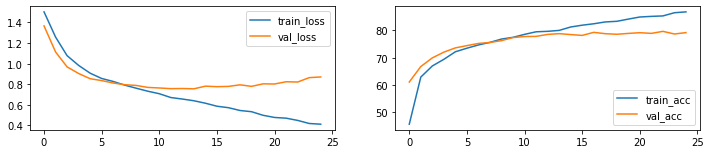

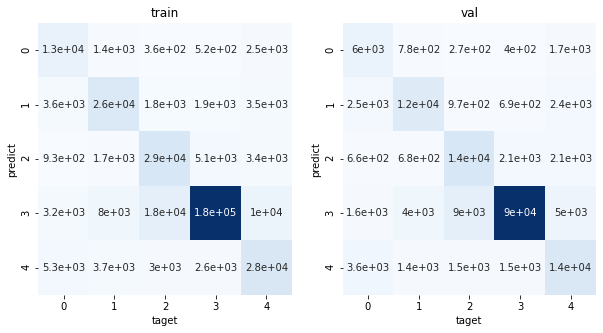

Loaded pretrained weights for efficientnet-b1
Kfold: 2 - Epoch: 1 - Train_Loss: 1.506560 - Train_Acc: 40.7361 - Val_Loss: 1.348873 - Val_Acc: 59.155917
Kfold: 2 - Epoch: 2 - Train_Loss: 1.249331 - Train_Acc: 61.6824 - Val_Loss: 1.109191 - Val_Acc: 65.269209
Kfold: 2 - Epoch: 3 - Train_Loss: 1.076121 - Train_Acc: 66.8209 - Val_Loss: 0.974718 - Val_Acc: 68.802580
Kfold: 2 - Epoch: 4 - Train_Loss: 0.973970 - Train_Acc: 69.8563 - Val_Loss: 0.902967 - Val_Acc: 71.536736
Kfold: 2 - Epoch: 5 - Train_Loss: 0.905652 - Train_Acc: 72.1416 - Val_Loss: 0.863930 - Val_Acc: 72.868761
Kfold: 2 - Epoch: 6 - Train_Loss: 0.854066 - Train_Acc: 73.5577 - Val_Loss: 0.836651 - Val_Acc: 73.794167
Kfold: 2 - Epoch: 7 - Train_Loss: 0.828740 - Train_Acc: 74.9246 - Val_Loss: 0.808739 - Val_Acc: 75.252384
Kfold: 2 - Epoch: 8 - Train_Loss: 0.786680 - Train_Acc: 75.8009 - Val_Loss: 0.800062 - Val_Acc: 75.098149
Kfold: 2 - Epoch: 9 - Train_Loss: 0.761695 - Train_Acc: 76.6912 - Val_Loss: 0.776418 - Val_Acc: 76.009534


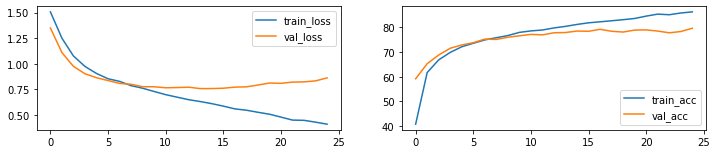

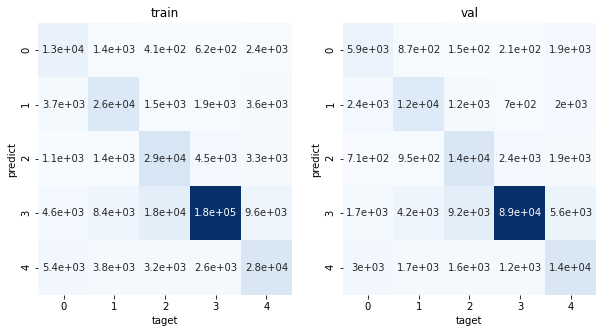

Loaded pretrained weights for efficientnet-b1
Kfold: 3 - Epoch: 1 - Train_Loss: 1.512565 - Train_Acc: 45.3347 - Val_Loss: 1.385658 - Val_Acc: 60.193494
Kfold: 3 - Epoch: 2 - Train_Loss: 1.266181 - Train_Acc: 62.6639 - Val_Loss: 1.138996 - Val_Acc: 65.549635
Kfold: 3 - Epoch: 3 - Train_Loss: 1.081486 - Train_Acc: 65.9586 - Val_Loss: 1.004524 - Val_Acc: 67.877173
Kfold: 3 - Epoch: 4 - Train_Loss: 0.986721 - Train_Acc: 69.4988 - Val_Loss: 0.923373 - Val_Acc: 71.396523
Kfold: 3 - Epoch: 5 - Train_Loss: 0.917727 - Train_Acc: 72.2538 - Val_Loss: 0.877576 - Val_Acc: 72.616377
Kfold: 3 - Epoch: 6 - Train_Loss: 0.866692 - Train_Acc: 73.1721 - Val_Loss: 0.854703 - Val_Acc: 73.808188
Kfold: 3 - Epoch: 7 - Train_Loss: 0.815075 - Train_Acc: 75.1630 - Val_Loss: 0.821814 - Val_Acc: 75.785193
Kfold: 3 - Epoch: 8 - Train_Loss: 0.784878 - Train_Acc: 75.5766 - Val_Loss: 0.806100 - Val_Acc: 75.252384
Kfold: 3 - Epoch: 9 - Train_Loss: 0.754434 - Train_Acc: 76.6772 - Val_Loss: 0.808035 - Val_Acc: 76.318003


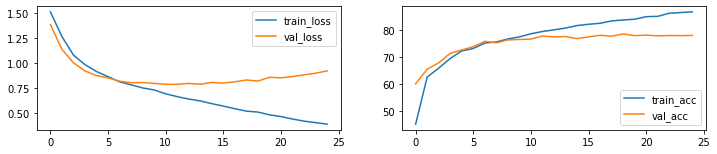

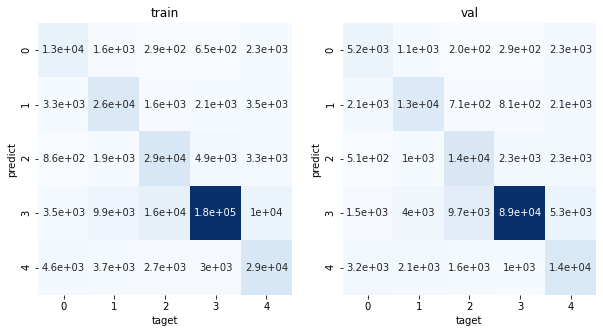

In [12]:
# n_splitsでKの数を指定
folds = StratifiedKFold(n_splits=CFG.n_split).split(np.arange(df_train.shape[0]), df_train["label"].values)
Save_histroy(init=True)
for fold_index, (train_index,val_index) in enumerate(folds):
    model = EfficientNet.from_pretrained(CFG.model_name)
    num_ftrs = model._fc.in_features
    model._fc = nn.Linear(num_ftrs, CFG.target_size)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate)
    
    train = df_train.iloc[train_index].reset_index(drop=True)
    train_data = ImageData(df = train, data_dir = train_dir, transform = data_transforms)
    train_loader = DataLoader(dataset = train_data, batch_size = CFG.batch_size, num_workers=CFG.num_workers, pin_memory=True,shuffle=True)
    train_criterion = nn.CrossEntropyLoss(weight=CFG.weights).to(device)
    
    val = df_train.iloc[val_index,:].reset_index(drop=True)
    val_data = ImageData(df = val, data_dir = train_dir, transform = data_transforms)
    val_loader = DataLoader(dataset = val_data, batch_size = CFG.batch_size, num_workers=CFG.num_workers, pin_memory=True,shuffle=True)
    val_criterion = nn.CrossEntropyLoss(weight=CFG.weights).to(device)
    train_epoch_log = []
    train_acc_log = []
    val_epoch_log = []
    val_acc_log = []
    train_taget_li = []
    train_pred_li = []
    val_taget_li = []
    val_pred_li = []
    for epoch in range(CFG.num_epochs):
        train_total = 0
        train_correct = 0
        train_loss_sum = 0
        val_total = 0
        val_correct = 0
        val_loss_sum = 0
        
        # train
        model.train()
        for idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = train_criterion(output, target)
            loss.backward()
            optimizer.step()  
            
            train_loss_sum += loss.item()
            train_total += target.size(0)
            _,predicted = output.max(1)
            train_correct += predicted.eq(target).sum().item()
            train_taget_li.extend(target.to('cpu').detach().numpy().copy().tolist())
            train_pred_li.extend(predicted.to('cpu').detach().numpy().copy().tolist())
            
            
        train_loss = train_loss_sum / len(train_loader)
        train_epoch_log.append(train_loss)
        train_acc = 100.0 * train_correct/train_total
        train_acc_log.append(train_acc)
        
        # val
        model.eval()
        with torch.no_grad():
            for idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = val_criterion(output, target)
                val_loss_sum += loss.item()
                val_total += target.size(0)
                _,predicted = output.max(1)
                val_correct += (predicted == target).sum().item()
                val_taget_li.extend(target.to('cpu').detach().numpy().copy().tolist())
                val_pred_li.extend(predicted.to('cpu').detach().numpy().copy().tolist())
                    
            val_loss = val_loss_sum / len(val_loader)
            val_epoch_log.append(val_loss)
            val_acc = 100.0 * val_correct/val_total
            val_acc_log.append(val_acc)
                
        print('Kfold: {} - Epoch: {} - Train_Loss: {:.6f} - Train_Acc: {:.4f} - Val_Loss: {:.6f} - Val_Acc: {:4f}'.format(fold_index+1, epoch + 1, train_loss, train_acc, val_loss, val_acc))
        Save_histroy(init=False)
        if (val_loss < CFG.checkpoint_thres_loss) & (val_acc > CFG.checkpoint_thres_acc):
            CFG.checkpoint_thres_loss = val_loss
            CFG.checkpoint_thres_acc = val_acc
            path = create_directory + "./efficientb1_epoch"+str(epoch)+ "_Acc_" + str(val_acc) + '.pth'
            torch.save(model.state_dict(), path) 
        
    Plot_Model_History(train_epoch_log,train_acc_log,val_epoch_log,val_acc_log)
    Confusion_Matrix(train_taget_li,train_pred_li,val_taget_li,val_pred_li)